In [1]:
from __future__ import print_function
import numpy as np

import sys, os

from PIL import Image

import matplotlib.pyplot as plt
import shutil, random

import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.models as models


In [2]:
import data_modification as dm
from train_test import start_train_test
import config as cf

use_cuda = torch.cuda.is_available()

train_dir = os.path.join('Data','Train')
test_dir = os.path.join('Data','Test')

dm.to3_channel(train_dir)
dm.create_train_test(train_dir,test_dir)

In [12]:
def transform_training():

    transform_train = transforms.Compose([
        transforms.Resize(cf.resize),
        transforms.CenterCrop(cf.crop_size),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])])

    return transform_train

def transform_testing():

    transform_test = transforms.Compose([
        transforms.Resize(cf.resize),
        transforms.CenterCrop(cf.crop_size),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    return transform_test


def dataset_split(train_dir,test_dir):
    trainset = torchvision.datasets.ImageFolder(root= train_dir, transform=transform_training())
    testset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform_testing())
    outputs = 10
    inputs=3
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=cf.batch_size, shuffle=True, num_workers=4)
    testloader = torch.utils.data.DataLoader(testset, batch_size=cf.batch_size, shuffle=False, num_workers=4)
    
    return trainloader, testloader, outputs, inputs

In [13]:
trainloader, testloader, outputs, inputs = dataset_split(train_dir,test_dir)
print ('Output classes: {}\nInput channels: {}'.format(outputs, inputs))

Output classes: 10
Input channels: 3


In [14]:
pretrained_alexnet = models.alexnet(pretrained=True)
for param in pretrained_alexnet.parameters():
    param.requires_grad = False
num_input_features = pretrained_alexnet.classifier[6].in_features
pretrained_alexnet.classifier[6] = nn.Linear(num_input_features, outputs)
pretrained_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [ ]:
if use_cuda:
    pretrained_alexnet.cuda()
    pretrained_alexnet = torch.nn.DataParallel(pretrained_alexnet, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
criterion.cuda()

train_loss, test_loss = start_train_test(pretrained_alexnet, trainloader, testloader, criterion)


=> Training Epoch #1, LR=0.0001
| Epoch [  1/ 10] 		Loss: 1.2438 Acc@1: 33.000%

| Validation Epoch #1			Loss: 1.0882 Acc@1: 46.00%
* Test results : Acc@1 = 66.00%
| Elapsed time : 0:01:39

=> Training Epoch #2, LR=0.0001


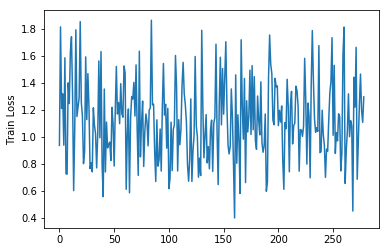

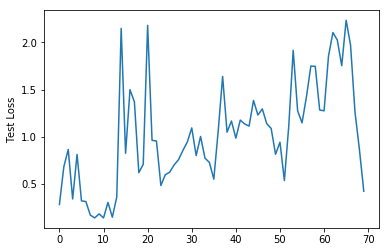

In [7]:
plt.plot(train_loss)
plt.ylabel('Train Loss')
plt.show()

plt.plot(test_loss)
plt.ylabel('Test Loss')
plt.show()